# Temporal and spatial mismatch vs $t_0$: Spatial mismatch, loudest modes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE
from qnmfits.spatial_mapping_functions import *

plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

In [2]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_options = [("Lev4", "R2"), ("Lev4", "R3"), ("Lev5", "R3")]

sims = []

for lev, R in sim_options:
    try:
        sim = CCE.SXS_CCE(id, lev=lev, radius=R)
        sims.append(sim)
    except:
        pass

In [3]:
l_max = 8
n_max = 7

In [4]:
t0_array = np.linspace(-30, 100, 100)

mappings = [
    [(2, 2, 0, 1)],
    [(3, 2, 0, 1)],
    [(4, 4, 0, 1)],
    [(5, 4, 0, 1)],
    [(6, 6, 0, 1)],
]

In [5]:
sm_array = np.zeros((len(mappings), len(t0_array)))
data_sm_array = np.zeros((len(mappings), len(t0_array)))

for i, mapping in enumerate(mappings):

    print(mapping)

    map = mapping[0]

    lp, mp, npp, pp = map

    QNMs = [(lam, mp, n, p) for lam in np.arange(mp, l_max + 1) for n in np.arange(0, n_max + 1) for p in (-1, +1)]

    for j, step in enumerate(t0_array):

        best_fit = mapping_multimode_ringdown_fit(
            sim_main.times,
            sim_main.h,
            modes=QNMs.copy(),
            Mf=sim_main.Mf,
            chif=sim_main.chif_mag,
            t0=step,
            mapping_modes=mapping,
            spherical_modes=[(lam, mp) for lam in np.arange(mp, l_max + 1)],
        )

        sm, _, _ = spatial_mismatch_linear(best_fit, map, sim_main.chif_mag, l_max)
        sm_array[i][j] = sm

        for sim in sims:

            best_fit_alt = mapping_multimode_ringdown_fit(
                sim.times,
                sim.h,
                modes=QNMs.copy(),
                Mf=sim.Mf,
                chif=sim.chif_mag,
                t0=step,
                mapping_modes=mapping,
                spherical_modes=[(lam, mp) for lam in np.arange(mp, l_max + 1)],
            )

            data_sm = spatial_data_mismatch(best_fit, best_fit_alt, map)
            if data_sm > data_sm_array[i][j]:
                data_sm_array[i][j] = data_sm

[(2, 2, 0, 1)]
[(3, 2, 0, 1)]
[(4, 4, 0, 1)]
[(5, 4, 0, 1)]
[(6, 6, 0, 1)]


/tmp/ipykernel_45404/391113270.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors2 = plt.cm.get_cmap("viridis", len(mappings))


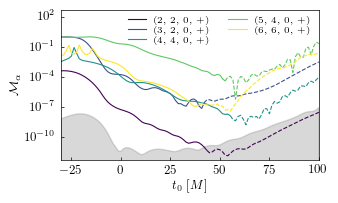

In [6]:
fig, ax = plt.subplots(figsize=(fig_width * 1.015, fig_height), ncols=1, nrows=1, sharex=True)
colors2 = plt.cm.get_cmap("viridis", len(mappings))

for i, mapping in enumerate(mappings):

    line_error_index = np.less(data_sm_array[i], sm_array[i])
    first_false_index = np.argmax(~line_error_index)

    if not np.all(line_error_index):
        line_error_index[first_false_index:] = False

    ax.plot(
        t0_array[line_error_index],
        sm_array[i][line_error_index],
        color=colors2(i),
        label=f"({mapping[0][0]}, {mapping[0][1]}, {mapping[0][2]}, +)",
    )
    ax.plot(
        t0_array[first_false_index - 1 : first_false_index + 1],
        sm_array[i][first_false_index - 1 : first_false_index + 1],
        color=colors2(i),
        linestyle="--",
    )
    ax.plot(
        t0_array[~line_error_index],
        sm_array[i][~line_error_index],
        color=colors2(i),
        linestyle="--",
    )

    if mapping == [(2, 2, 0, 1)]:
        ax.fill_between(t0_array, data_sm_array[i], color="grey", alpha=0.3)

ax.set_xlabel("$t_0 \ [M]$")
ax.set_yscale("log")
ax.set_ylabel(r"$\mathcal{M}_{\alpha}$")
ax.legend(
    loc="upper right",
    ncol=2,
    fontsize=6.7,
    bbox_to_anchor=(1.0, 1.02),
    labelspacing=0.1,
)
ax.set_xlim(np.min(t0_array), np.max(t0_array))
ax.set_ylim(5e-13, 5e2)

plt.show()
fig.savefig("figs/sm_mismatch_loudest.pdf", bbox_inches="tight")